In [1]:
import subprocess
subprocess.run(['pip', 'install', 'neurokit2', 'scikit-learn', 'matplotlib',
                'seaborn', 'pandas', 'numpy', 'scipy', 'tqdm', 'xgboost'], 
               capture_output=True)
print('All packages installed! Restart kernel now, then run from Cell 2.')

All packages installed! Restart kernel now, then run from Cell 2.


In [1]:
import os, warnings, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

from scipy import stats
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

try:
    import neurokit2 as nk
    NK_AVAILABLE = True
    print('neurokit2 available')
except:
    NK_AVAILABLE = False
    print('neurokit2 NOT available - using manual peak detection')

print('Imports done!')

neurokit2 NOT available - using manual peak detection
Imports done!


In [3]:
# ============================================================
# CHANGE THIS PATH IF NEEDED
DATASET_PATH = '/Users/prateekchoudhary/Downloads/CAN-STRESS'
# ============================================================

all_folders = sorted([
    f for f in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, f)) and f.startswith('A01')
])

print(f'Dataset Path   : {DATASET_PATH}')
print(f'Sessions Found : {len(all_folders)}')
print(f'First 5 folders: {all_folders[:5]}')

# Preview files in first folder
first = os.path.join(DATASET_PATH, all_folders[0])
print(f'\nFiles in {all_folders[0]}:')
for fname in sorted(os.listdir(first)):
    fpath = os.path.join(first, fname)
    print(f'  {fname:20s}  {os.path.getsize(fpath)/1024:.1f} KB')

Dataset Path   : /Users/prateekchoudhary/Downloads/CAN-STRESS
Sessions Found : 55
First 5 folders: ['A01BB3_220304-144010__1463069', 'A01BB3_220309-140348__1467167', 'A01BB3_220323-133317__1476005', 'A01BB3_220323-133317__1476005 2', 'A01BB3_220323-133317__1476005 3']

Files in A01BB3_220304-144010__1463069:
  ACC.csv               24973.7 KB
  BVP.csv               33944.9 KB
  EDA.csv               3052.3 KB
  HR.csv                517.3 KB
  IBI.csv               962.6 KB
  TEMP.csv              2034.9 KB
  info.txt              1.5 KB
  tags.csv              0.0 KB


In [4]:
first_folder = os.path.join(DATASET_PATH, all_folders[0])

for fname in ['EDA.csv', 'HR.csv', 'ACC.csv', 'BVP.csv', 'TEMP.csv', 'IBI.csv', 'tags.csv']:
    fpath = os.path.join(first_folder, fname)
    if os.path.exists(fpath):
        raw = pd.read_csv(fpath, header=None)
        print(f'\n=== {fname} ===')
        print(f'Shape: {raw.shape}')
        print(raw.head(5).to_string())


=== EDA.csv ===
Shape: (347282, 1)
              0
0  1.646405e+09
1  4.000000e+00
2  0.000000e+00
3  2.815900e-02
4  5.375800e-02

=== HR.csv ===
Shape: (86813, 1)
              0
0  1.646405e+09
1  1.000000e+00
2  5.500000e+01
3  5.500000e+01
4  5.600000e+01

=== ACC.csv ===
Shape: (2778248, 3)
              0             1             2
0  1.646405e+09  1.646405e+09  1.646405e+09
1  3.200000e+01  3.200000e+01  3.200000e+01
2  3.700000e+01  3.700000e+01  1.000000e+00
3  5.500000e+01  3.800000e+01 -4.000000e+00
4  5.600000e+01  3.700000e+01 -2.000000e+00

=== BVP.csv ===
Shape: (5556498, 1)
              0
0  1.646405e+09
1  6.400000e+01
2 -0.000000e+00
3 -0.000000e+00
4 -0.000000e+00

=== TEMP.csv ===
Shape: (347282, 1)
              0
0  1.646405e+09
1  4.000000e+00
2  3.266000e+01
3  3.266000e+01
4  3.266000e+01

=== IBI.csv ===
Shape: (44989, 2)
              0         1
0  1.646405e+09       IBI
1  1.710938e+01  0.734375
2  1.789062e+01  0.781250
3  1.871875e+01  0.828125
4  1.9

In [5]:
def load_signal(filepath):
    """
    Empatica E4 format:
      Row 0 = start Unix timestamp
      Row 1 = sampling rate (Hz)
      Row 2+ = values
    """
    try:
        raw = pd.read_csv(filepath, header=None)
        start_ts    = float(raw.iloc[0, 0])
        sample_rate = float(raw.iloc[1, 0])
        values      = raw.iloc[2:].values
        n = len(values)
        timestamps = [start_ts + i / sample_rate for i in range(n)]

        if values.shape[1] == 1:
            return pd.DataFrame({'timestamp': timestamps,
                                 'value': values[:, 0].astype(float)})
        else:  # ACC: 3 columns
            d = {'timestamp': timestamps}
            for i in range(values.shape[1]):
                d[f'axis_{i}'] = values[:, i].astype(float)
            return pd.DataFrame(d)
    except:
        return None


def load_ibi(filepath):
    try:
        raw = pd.read_csv(filepath, header=None)
        start_ts = float(raw.iloc[0, 0])
        data = raw.iloc[1:].copy()
        data.columns = ['offset', 'ibi']
        data['timestamp'] = start_ts + data['offset'].astype(float)
        data['ibi'] = data['ibi'].astype(float)
        return data[['timestamp', 'ibi']].reset_index(drop=True)
    except:
        return None


def load_tags(filepath):
    try:
        raw = pd.read_csv(filepath, header=None)
        return raw.iloc[:, 0].astype(float).tolist()
    except:
        return []


def load_participant(folder_path):
    data = {}
    for sig in ['EDA', 'HR', 'BVP', 'TEMP', 'ACC']:
        fp = os.path.join(folder_path, f'{sig}.csv')
        if os.path.exists(fp):
            data[sig] = load_signal(fp)
    ibi_fp = os.path.join(folder_path, 'IBI.csv')
    if os.path.exists(ibi_fp):
        data['IBI'] = load_ibi(ibi_fp)
    data['tags'] = load_tags(os.path.join(folder_path, 'tags.csv'))
    return data


print('Loader functions defined!')

# Quick test
test_data = load_participant(os.path.join(DATASET_PATH, all_folders[0]))
print('\nLoaded modalities:')
for k, v in test_data.items():
    if isinstance(v, pd.DataFrame):
        print(f'  {k:6s}: {len(v):,} rows | cols={list(v.columns)}')
    else:
        print(f'  tags  : {v}')

Loader functions defined!

Loaded modalities:
  EDA   : 347,280 rows | cols=['timestamp', 'value']
  HR    : 86,811 rows | cols=['timestamp', 'value']
  BVP   : 5,556,496 rows | cols=['timestamp', 'value']
  TEMP  : 347,280 rows | cols=['timestamp', 'value']
  ACC   : 2,778,246 rows | cols=['timestamp', 'axis_0', 'axis_1', 'axis_2']
  IBI   : 44,988 rows | cols=['timestamp', 'ibi']
  tags  : [1646428197.36, 1646449110.31]


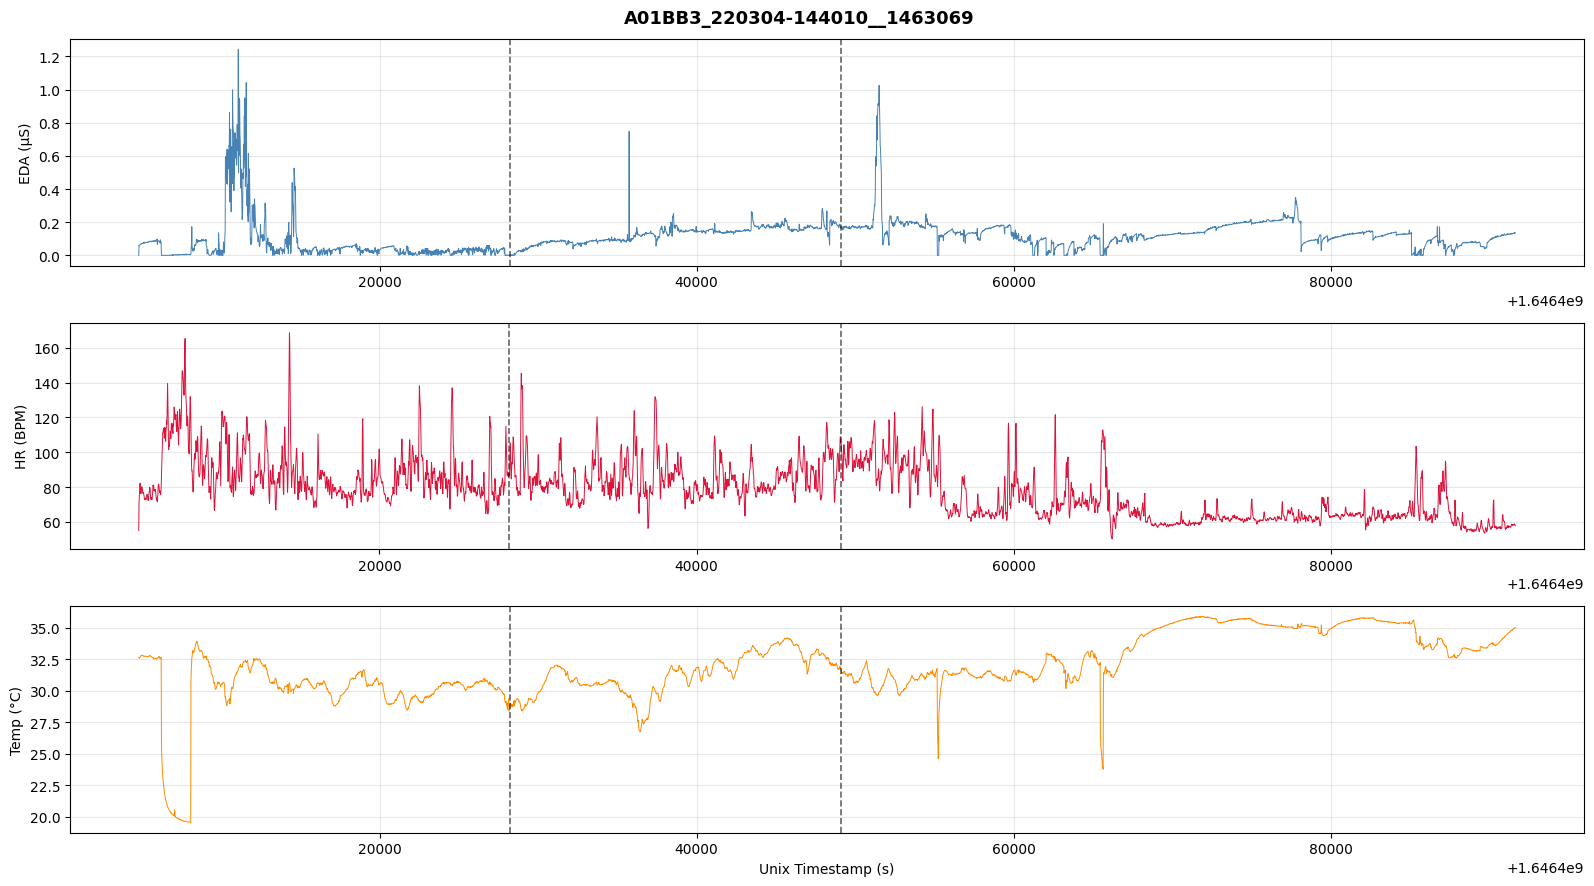

Saved: signals_preview.png


In [6]:
def plot_participant(data, title='', max_pts=5000):
    signals = [
        ('EDA',  'EDA (µS)',  'steelblue'),
        ('HR',   'HR (BPM)', 'crimson'),
        ('TEMP', 'Temp (°C)', 'darkorange'),
    ]
    fig, axes = plt.subplots(3, 1, figsize=(16, 9), sharex=False)
    fig.suptitle(title or 'Participant Signals', fontsize=13, fontweight='bold')

    for ax, (key, label, color) in zip(axes, signals):
        if key in data and data[key] is not None:
            df = data[key]
            step = max(1, len(df) // max_pts)
            d = df.iloc[::step]
            ax.plot(d['timestamp'], d['value'], color=color, linewidth=0.7)
            for tag in data.get('tags', []):
                if d['timestamp'].min() <= tag <= d['timestamp'].max():
                    ax.axvline(tag, color='black', linestyle='--', alpha=0.6, linewidth=1.2)
        ax.set_ylabel(label)
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Unix Timestamp (s)')
    plt.tight_layout()
    plt.savefig('signals_preview.png', dpi=110, bbox_inches='tight')
    plt.show()
    print('Saved: signals_preview.png')


plot_participant(test_data, title=all_folders[0])

In [7]:
def safe(arr, fn):
    try:
        v = fn(arr)
        return v if np.isfinite(v) else np.nan
    except:
        return np.nan


def feat_eda(arr, sr=4):
    f = {}
    arr = np.array(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if len(arr) < 4: return f

    f['eda_mean']     = safe(arr, np.mean)
    f['eda_std']      = safe(arr, np.std)
    f['eda_min']      = safe(arr, np.min)
    f['eda_max']      = safe(arr, np.max)
    f['eda_range']    = f['eda_max'] - f['eda_min']
    f['eda_skew']     = safe(arr, stats.skew)
    f['eda_kurtosis'] = safe(arr, stats.kurtosis)
    try:
        f['eda_slope'] = np.polyfit(np.arange(len(arr)), arr, 1)[0]
    except:
        f['eda_slope'] = np.nan

    # EDA Peaks Per Minute
    try:
        if NK_AVAILABLE:
            cleaned = nk.eda_clean(arr, sampling_rate=sr)
            _, info = nk.eda_peaks(cleaned, sampling_rate=sr)
            n_peaks = info['SCR_Peaks'].sum()
        else:
            diff1 = np.diff(arr)
            n_peaks = np.sum((diff1[:-1] > 0) & (diff1[1:] <= 0) & (arr[1:-1] > np.mean(arr)))
        f['eda_ppm'] = n_peaks / max(len(arr) / (sr * 60), 0.01)
    except:
        f['eda_ppm'] = np.nan

    return f


def feat_hr(arr):
    f = {}
    arr = np.array(arr, dtype=float)
    arr = arr[(arr > 40) & (arr < 200)]
    if len(arr) < 2: return f
    f['hr_mean']  = safe(arr, np.mean)
    f['hr_std']   = safe(arr, np.std)
    f['hr_min']   = safe(arr, np.min)
    f['hr_max']   = safe(arr, np.max)
    f['hr_range'] = f['hr_max'] - f['hr_min']
    f['hr_skew']  = safe(arr, stats.skew)
    try:
        f['hr_slope'] = np.polyfit(np.arange(len(arr)), arr, 1)[0]
    except:
        f['hr_slope'] = np.nan
    return f


def feat_hrv(ibi_arr):
    f = {}
    arr = np.array(ibi_arr, dtype=float)
    arr = arr[(arr > 0.3) & (arr < 2.0)]
    if len(arr) < 4: return f
    diffs = np.diff(arr)
    f['hrv_rmssd']    = np.sqrt(np.mean(diffs**2))
    f['hrv_sdnn']     = np.std(arr)
    f['hrv_mean_ibi'] = np.mean(arr)
    f['hrv_pnn50']    = np.mean(np.abs(diffs) > 0.05)
    return f


def feat_temp(arr):
    f = {}
    arr = np.array(arr, dtype=float)
    arr = arr[(arr > 20) & (arr < 45)]
    if len(arr) < 2: return f
    f['temp_mean']  = safe(arr, np.mean)
    f['temp_std']   = safe(arr, np.std)
    f['temp_min']   = safe(arr, np.min)
    f['temp_max']   = safe(arr, np.max)
    try:
        f['temp_slope'] = np.polyfit(np.arange(len(arr)), arr, 1)[0]
    except:
        f['temp_slope'] = np.nan
    return f


def feat_acc(acc_df):
    f = {}
    try:
        x = acc_df['axis_0'].values.astype(float)
        y = acc_df['axis_1'].values.astype(float)
        z = acc_df['axis_2'].values.astype(float)
        mag = np.sqrt(x**2 + y**2 + z**2)
        f['acc_mean']   = np.mean(mag)
        f['acc_std']    = np.std(mag)
        f['acc_max']    = np.max(mag)
        f['acc_motion'] = np.mean(np.abs(np.diff(mag)))
    except:
        pass
    return f


print('Feature extraction functions defined!')

Feature extraction functions defined!


In [8]:
def get_window(signal_df, t_start, t_end, val_col='value'):
    mask = (signal_df['timestamp'] >= t_start) & (signal_df['timestamp'] < t_end)
    return signal_df[mask][val_col].values


def extract_window(data, t_start, window_sec=60):
    t_end = t_start + window_sec
    feats = {}

    if 'EDA' in data and data['EDA'] is not None:
        feats.update(feat_eda(get_window(data['EDA'], t_start, t_end)))
    if 'HR' in data and data['HR'] is not None:
        feats.update(feat_hr(get_window(data['HR'], t_start, t_end)))
    if 'TEMP' in data and data['TEMP'] is not None:
        feats.update(feat_temp(get_window(data['TEMP'], t_start, t_end)))
    if 'IBI' in data and data['IBI'] is not None:
        feats.update(feat_hrv(get_window(data['IBI'], t_start, t_end, val_col='ibi')))
    if 'ACC' in data and data['ACC'] is not None:
        mask = (data['ACC']['timestamp'] >= t_start) & (data['ACC']['timestamp'] < t_end)
        feats.update(feat_acc(data['ACC'][mask]))

    return feats


def sliding_windows(data, window_sec=60, step_sec=30):
    if 'EDA' not in data or data['EDA'] is None:
        return []
    t_start = data['EDA']['timestamp'].min()
    t_end   = data['EDA']['timestamp'].max()
    records = []
    t = t_start
    while t + window_sec <= t_end:
        feats = extract_window(data, t, window_sec)
        feats['window_start'] = t
        records.append(feats)
        t += step_sec
    return records


print('Windowing functions defined!')

# Quick test
test_wins = sliding_windows(test_data)
print(f'Windows from first session: {len(test_wins)}')
print(f'Features per window: {len(test_wins[0])}')
print('Sample features:')
for k, v in list(test_wins[0].items())[:6]:
    print(f'  {k:20s}: {v:.4f}')

Windowing functions defined!
Windows from first session: 2892
Features per window: 30
Sample features:
  eda_mean            : 0.0579
  eda_std             : 0.0053
  eda_min             : 0.0000
  eda_max             : 0.0691
  eda_range           : 0.0691
  eda_skew            : -6.0836


In [9]:
# ============================================================
# LABELING STRATEGY:
#   tags.csv = event timestamps (cannabis use, exercise, etc.)
#   Windows within TAG_RADIUS seconds of a tag = event windows
#   All other windows = baseline windows
# ============================================================
WINDOW_SEC  = 60    # seconds
STEP_SEC    = 30    # step (50% overlap)
TAG_RADIUS  = 120   # seconds around a tag event

all_records = []
failed = []

print(f'Processing {len(all_folders)} sessions...')

for i, folder_name in enumerate(tqdm(all_folders)):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    try:
        data = load_participant(folder_path)
        if 'EDA' not in data or data['EDA'] is None:
            failed.append(folder_name)
            continue

        tags    = data.get('tags', [])
        records = sliding_windows(data, WINDOW_SEC, STEP_SEC)

        for rec in records:
            ws  = rec['window_start']
            mid = ws + WINDOW_SEC / 2
            near_tag = any(abs(mid - tag) < TAG_RADIUS for tag in tags)
            rec['label']          = 1 if near_tag else 0
            rec['participant_id'] = folder_name
            rec['session_idx']    = i
            all_records.append(rec)

    except Exception as e:
        failed.append(f'{folder_name}: {e}')


df = pd.DataFrame(all_records)
print(f'\nDone!')
print(f'Total windows : {len(df):,}')
print(f'Total features: {df.shape[1] - 3}')
print(f'Failed folders: {len(failed)}')
vc = df['label'].value_counts()
print(f'\nLabel distribution:')
print(f'  Baseline (0)      : {vc.get(0,0):,}')
print(f'  Event/Stress (1)  : {vc.get(1,0):,}')

Processing 55 sessions...


100%|██████████| 55/55 [06:06<00:00,  6.66s/it]



Done!
Total windows : 121,540
Total features: 30
Failed folders: 0

Label distribution:
  Baseline (0)      : 120,583
  Event/Stress (1)  : 957


In [10]:
META = ['participant_id', 'session_idx', 'window_start', 'label']
feature_cols = [c for c in df.columns if c not in META]

# Drop features with >50% missing
missing_pct = df[feature_cols].isnull().mean()
drop_cols   = missing_pct[missing_pct > 0.5].index.tolist()
print(f'Dropping {len(drop_cols)} features with >50% missing: {drop_cols}')
feature_cols = [c for c in feature_cols if c not in drop_cols]

print(f'Final feature count: {len(feature_cols)}')
print(f'Features: {feature_cols}')

# Summary stats
print('\nFeature Summary:')
print(df[feature_cols].describe().round(3).to_string())

# Save feature data
df.to_csv('can_stress_features.csv', index=False)
print('\nSaved: can_stress_features.csv')

Dropping 0 features with >50% missing: []
Final feature count: 29
Features: ['eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_range', 'eda_skew', 'eda_kurtosis', 'eda_slope', 'eda_ppm', 'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_range', 'hr_skew', 'hr_slope', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_slope', 'hrv_rmssd', 'hrv_sdnn', 'hrv_mean_ibi', 'hrv_pnn50', 'acc_mean', 'acc_std', 'acc_max', 'acc_motion']

Feature Summary:
         eda_mean     eda_std     eda_min     eda_max   eda_range    eda_skew  eda_kurtosis   eda_slope     eda_ppm     hr_mean      hr_std      hr_min      hr_max    hr_range     hr_skew    hr_slope   temp_mean    temp_std    temp_min    temp_max  temp_slope  hrv_rmssd   hrv_sdnn  hrv_mean_ibi  hrv_pnn50    acc_mean     acc_std     acc_max  acc_motion
count  121540.000  121540.000  121540.000  121540.000  121540.000  120339.000    120339.000  121540.000  121540.000  121239.000  121239.000  121239.000  121239.000  121239.000  121239.000  121239.000

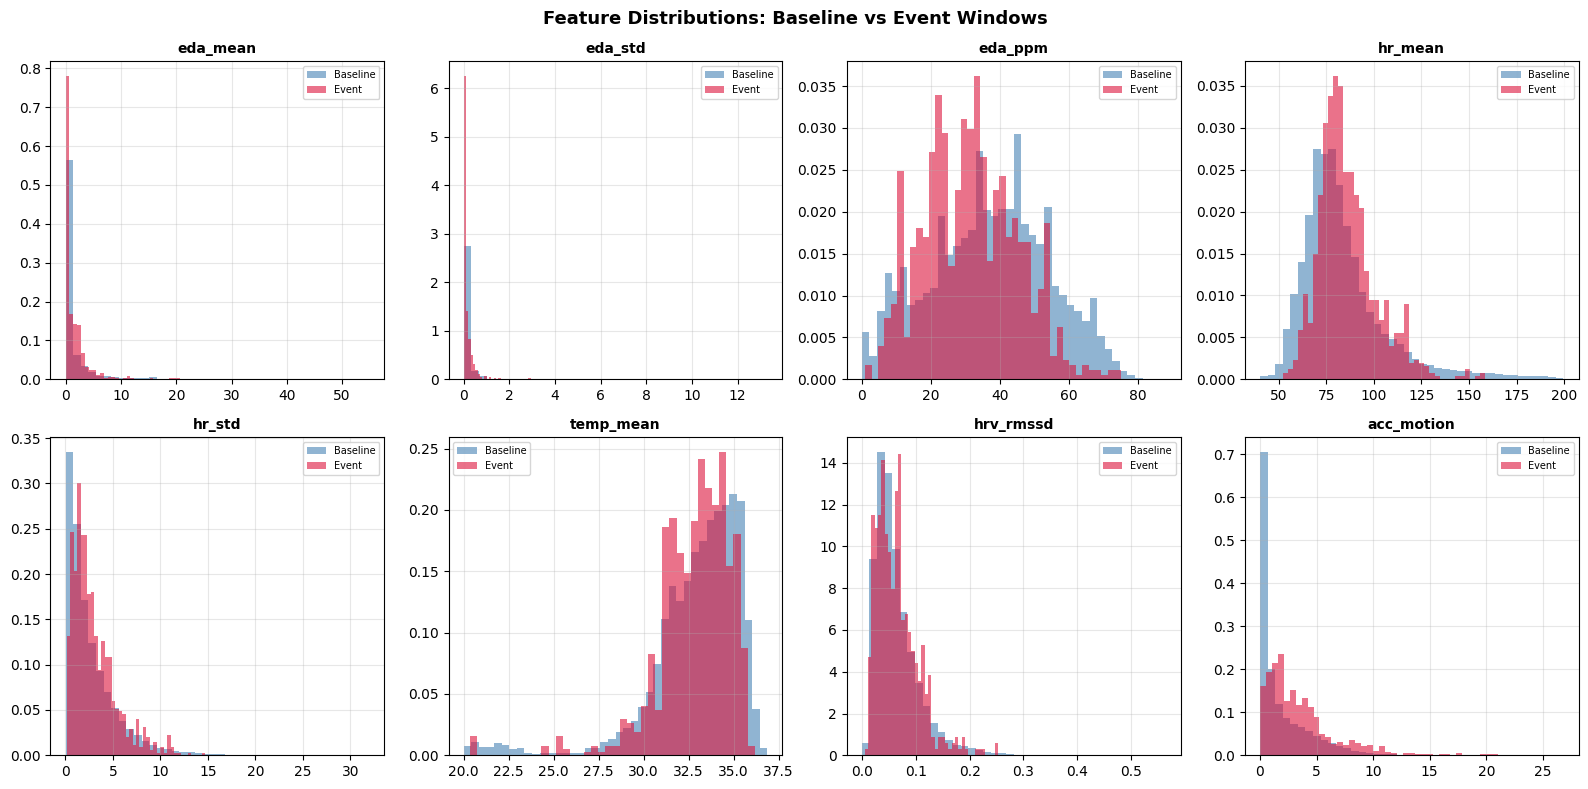

Saved: feature_distributions.png


In [11]:
key_feats = [f for f in
    ['eda_mean', 'eda_std', 'eda_ppm', 'hr_mean', 'hr_std', 'temp_mean', 'hrv_rmssd', 'acc_motion']
    if f in df.columns]

n = len(key_feats)
ncols = 4
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))
axes = axes.flatten()

for ax, feat in zip(axes, key_feats):
    for lbl, color, name in [(0,'steelblue','Baseline'), (1,'crimson','Event')]:
        vals = df[df['label'] == lbl][feat].dropna()
        ax.hist(vals, bins=40, alpha=0.6, color=color, label=name, density=True)
    ax.set_title(feat, fontsize=10, fontweight='bold')
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

for ax in axes[n:]:
    ax.set_visible(False)

plt.suptitle('Feature Distributions: Baseline vs Event Windows', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=110, bbox_inches='tight')
plt.show()
print('Saved: feature_distributions.png')

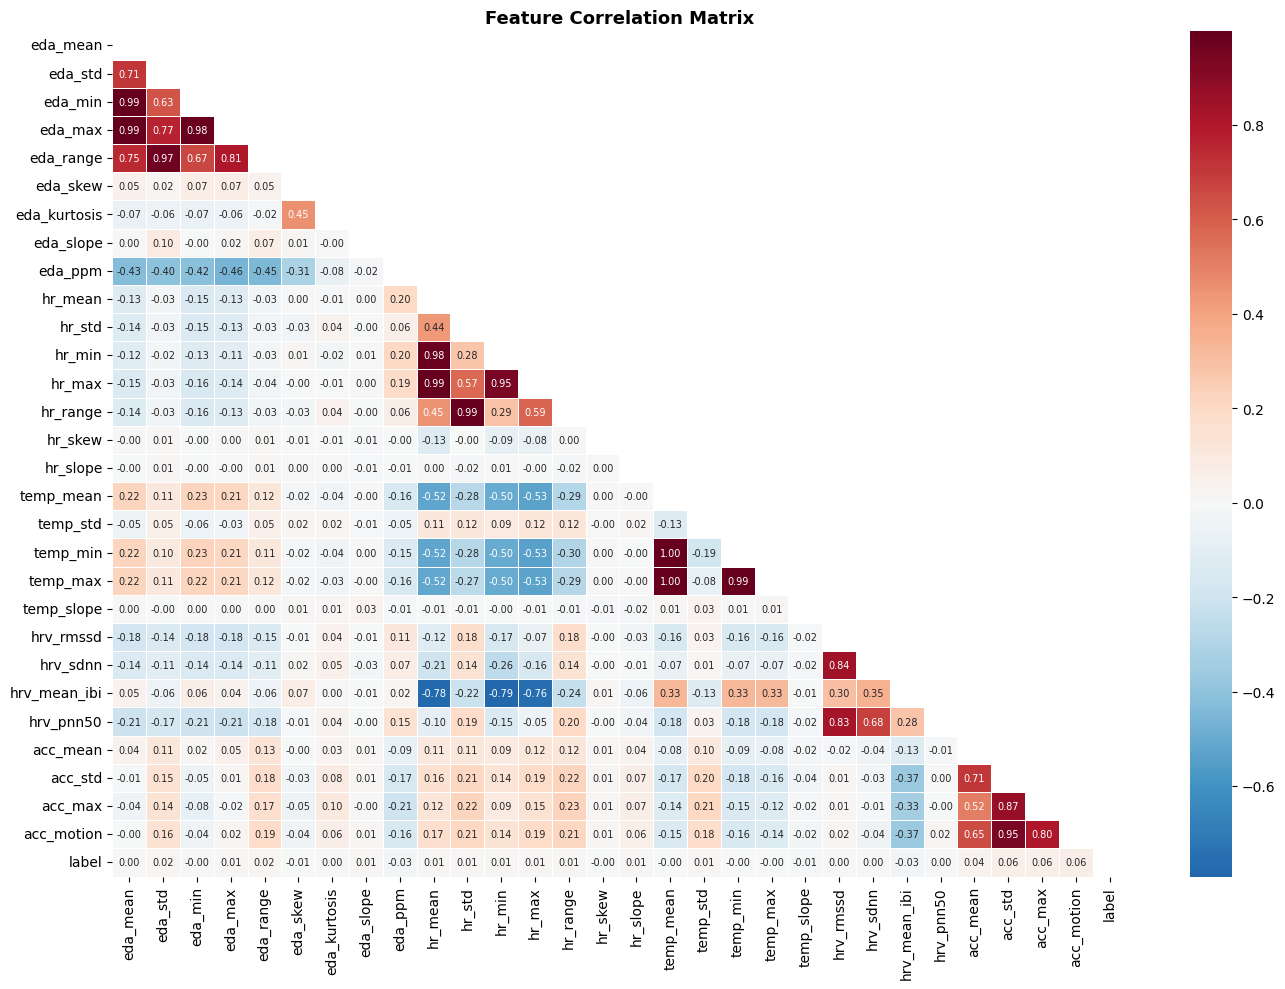

Saved: correlation_heatmap.png


In [12]:
plt.figure(figsize=(14, 10))
corr = df[feature_cols + ['label']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.4, annot_kws={'size': 7})
plt.title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=110, bbox_inches='tight')
plt.show()
print('Saved: correlation_heatmap.png')

In [13]:
X_raw = df[feature_cols].values
y     = df['label'].values

# Impute NaN with median
imputer = SimpleImputer(strategy='median')
X_imp   = imputer.fit_transform(X_raw)

# Scale
scaler  = StandardScaler()
X       = scaler.fit_transform(X_imp)

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')
pos_pct = (y==1).mean()*100
neg_pct = (y==0).mean()*100
print(f'Baseline: {(y==0).sum():,} ({neg_pct:.1f}%)')
print(f'Event   : {(y==1).sum():,} ({pos_pct:.1f}%)')

# Check imbalance
ratio = (y==1).sum() / (y==0).sum()
print(f'\nImbalance ratio (event/baseline): {ratio:.3f}')
if ratio < 0.3:
    print('Class imbalance detected - models will use class_weight=balanced')

X shape : (121540, 29)
y shape : (121540,)
Baseline: 120,583 (99.2%)
Event   : 957 (0.8%)

Imbalance ratio (event/baseline): 0.008
Class imbalance detected - models will use class_weight=balanced


In [14]:
pos_neg_ratio = (y==0).sum() / max((y==1).sum(), 1)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        scale_pos_weight=pos_neg_ratio,
        eval_metric='logloss', random_state=42, verbosity=0
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print('5-Fold Cross Validation (F1 Score):')
print('='*50)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)
    results[name] = scores
    print(f'{name:25s}: {scores.mean():.3f} +/- {scores.std():.3f}')

print('='*50)
best_name = max(results, key=lambda k: results[k].mean())
print(f'\nBest Model: {best_name} (F1={results[best_name].mean():.3f})')

5-Fold Cross Validation (F1 Score):
Random Forest            : 0.060 +/- 0.002
XGBoost                  : 0.101 +/- 0.009
Gradient Boosting        : 0.131 +/- 0.017
Logistic Regression      : 0.030 +/- 0.001

Best Model: Gradient Boosting (F1=0.131)


Train: 95,794 | Test: 25,746

=== Gradient Boosting Test Results ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00     25624
       Event       0.39      0.11      0.18       122

    accuracy                           0.99     25746
   macro avg       0.69      0.56      0.59     25746
weighted avg       0.99      0.99      0.99     25746



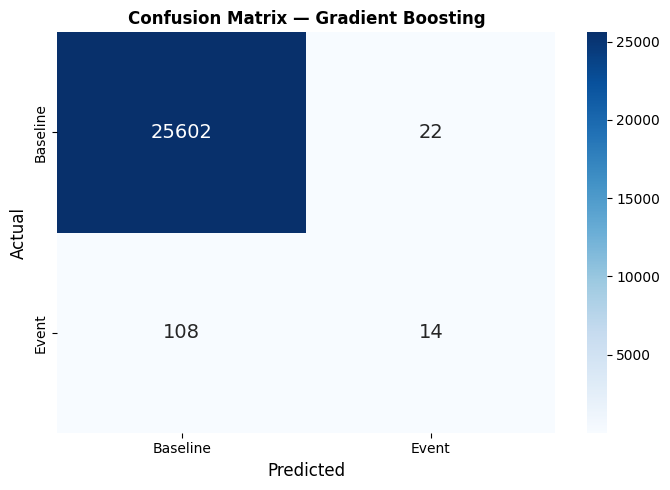

Saved: confusion_matrix.png


In [15]:
# Split by session (not by row) to avoid data leakage
unique_sessions = df['session_idx'].unique()
train_sess, test_sess = train_test_split(unique_sessions, test_size=0.2, random_state=42)

tr_mask = df['session_idx'].isin(train_sess)
te_mask = df['session_idx'].isin(test_sess)

X_train, X_test = X[tr_mask], X[te_mask]
y_train, y_test = y[tr_mask], y[te_mask]

print(f'Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}')

# Train and evaluate
best_model = models[best_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f'\n=== {best_name} Test Results ===')
print(classification_report(y_test, y_pred, target_names=['Baseline', 'Event']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baseline','Event'],
            yticklabels=['Baseline','Event'],
            annot_kws={'size': 14})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix — {best_name}', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=110, bbox_inches='tight')
plt.show()
print('Saved: confusion_matrix.png')

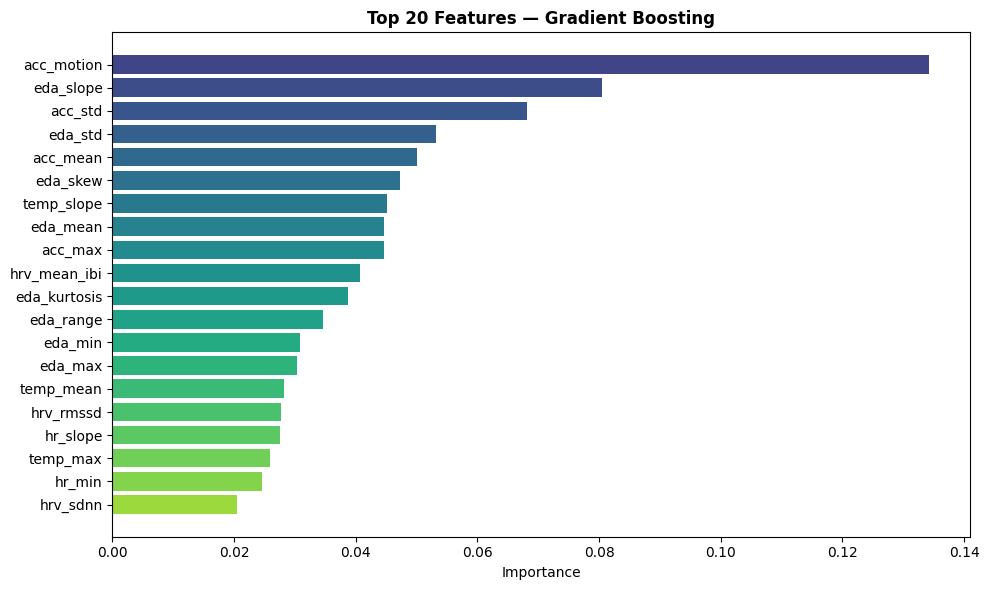

Saved: feature_importance.png
     feature  importance
  acc_motion    0.134237
   eda_slope    0.080461
     acc_std    0.068119
     eda_std    0.053163
    acc_mean    0.050068
    eda_skew    0.047300
  temp_slope    0.045115
    eda_mean    0.044693
     acc_max    0.044561
hrv_mean_ibi    0.040699
eda_kurtosis    0.038690
   eda_range    0.034573
     eda_min    0.030902
     eda_max    0.030339
   temp_mean    0.028116
   hrv_rmssd    0.027660
    hr_slope    0.027549
    temp_max    0.025877
      hr_min    0.024580
    hrv_sdnn    0.020530
    temp_min    0.019120
    temp_std    0.018487
     hr_skew    0.014241
     eda_ppm    0.010596
      hr_std    0.009698
     hr_mean    0.008078
      hr_max    0.008049
    hr_range    0.007354
   hrv_pnn50    0.007143


In [16]:
if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({'feature': feature_cols,
                       'importance': best_model.feature_importances_})\
           .sort_values('importance', ascending=False)

    top_n = min(20, len(fi))
    plt.figure(figsize=(10, 6))
    colors_bar = plt.cm.viridis(np.linspace(0.2, 0.85, top_n))
    plt.barh(fi['feature'][:top_n], fi['importance'][:top_n], color=colors_bar)
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features — {best_name}', fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=110, bbox_inches='tight')
    plt.show()
    print('Saved: feature_importance.png')
    print(fi.to_string(index=False))

In [17]:
from datetime import datetime

bundle = {
    'model':        best_model,
    'scaler':       scaler,
    'imputer':      imputer,
    'feature_cols': feature_cols,
    'model_name':   best_name,
    'accuracy':     accuracy_score(y_test, y_pred),
    'trained_at':   datetime.now().isoformat(),
}
with open('stress_model.pkl', 'wb') as f:
    pickle.dump(bundle, f)

print('Saved: stress_model.pkl')
print(f'\n=== FINAL SUMMARY ===')
print(f'  Sessions  : {len(all_folders)}')
print(f'  Windows   : {len(df):,}')
print(f'  Features  : {len(feature_cols)}')
print(f'  Model     : {best_name}')
print(f'  Accuracy  : {accuracy_score(y_test, y_pred)*100:.1f}%')

Saved: stress_model.pkl

=== FINAL SUMMARY ===
  Sessions  : 55
  Windows   : 121,540
  Features  : 29
  Model     : Gradient Boosting
  Accuracy  : 99.5%


In [18]:
def predict_session(folder_path, model_path='stress_model.pkl'):
    with open(model_path, 'rb') as f:
        b = pickle.load(f)

    data    = load_participant(folder_path)
    records = sliding_windows(data)
    if not records:
        print('No windows extracted!')
        return None

    feat_df = pd.DataFrame(records)
    for col in b['feature_cols']:
        if col not in feat_df.columns:
            feat_df[col] = np.nan

    X_new = feat_df[b['feature_cols']].values
    X_new = b['imputer'].transform(X_new)
    X_new = b['scaler'].transform(X_new)

    preds = b['model'].predict(X_new)
    probs = b['model'].predict_proba(X_new)[:, 1]

    result = pd.DataFrame({
        'window_start': feat_df['window_start'],
        'window_end'  : feat_df['window_start'] + 60,
        'prediction'  : preds,
        'stress_prob' : probs.round(3)
    })

    n_events = (preds == 1).sum()
    print(f'Session: {os.path.basename(folder_path)}')
    print(f'Windows     : {len(result)}')
    print(f'Events found: {n_events} ({n_events/len(result)*100:.1f}%)')
    print(f'Avg prob    : {probs.mean():.3f}')
    return result


# Test on first session
r = predict_session(os.path.join(DATASET_PATH, all_folders[0]))
if r is not None:
    print(r.head(10).to_string(index=False))

Session: A01BB3_220304-144010__1463069
Windows     : 2892
Events found: 8 (0.3%)
Avg prob    : 0.007
 window_start   window_end  prediction  stress_prob
 1646404810.0 1646404870.0           0        0.003
 1646404840.0 1646404900.0           0        0.001
 1646404870.0 1646404930.0           0        0.001
 1646404900.0 1646404960.0           0        0.001
 1646404930.0 1646404990.0           0        0.001
 1646404960.0 1646405020.0           0        0.001
 1646404990.0 1646405050.0           0        0.001
 1646405020.0 1646405080.0           0        0.001
 1646405050.0 1646405110.0           0        0.001
 1646405080.0 1646405140.0           0        0.001


In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])


Best Threshold: 0.3836124042878194
Best F1: 0.25287355902761266


In [20]:
y_pred_new = (y_prob > best_threshold).astype(int)
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25624
           1       0.40      0.16      0.23       122

    accuracy                           0.99     25746
   macro avg       0.70      0.58      0.61     25746
weighted avg       0.99      0.99      0.99     25746



In [23]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipeline = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.03,
        scale_pos_weight=pos_neg_ratio,
        eval_metric='logloss',
        random_state=42
    ))
])



In [24]:
pipeline.fit(X_train, y_train)
y_prob = pipeline.predict_proba(X_test)[:,1]


In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2*(precision*recall)/(precision+recall+1e-8)

best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", f1[best_idx])


Best threshold: 0.99812084
Best F1: 0.172727267786777


In [26]:
y_pred = (y_prob > best_threshold).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25624
           1       0.18      0.14      0.16       122

    accuracy                           0.99     25746
   macro avg       0.59      0.57      0.58     25746
weighted avg       0.99      0.99      0.99     25746



In [27]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(
    XGBClassifier(n_estimators=200),
    threshold='median'
)

X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)


In [28]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__max_depth': [3,4,5,6],
    'model__learning_rate': [0.01,0.03,0.05],
    'model__n_estimators': [200,300,400]
}

search = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

search.fit(X_train, y_train)


/Users/prateekchoudhary/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/prateekchoudhary/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/prateekchoudhary/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=Fa...
                                                            max_delta_step=None,
                                                            max_depth=5,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=300,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.03,
                                                                 0.05],
                                        'model__max_depth': [3, 4, 5, 6],
                                        'model__n_estimators': [200, 300, 400]},
                   scoring='f1')

In [29]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_dummy))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25624
           1       0.00      0.00      0.00       122

    accuracy                           1.00     25746
   macro avg       0.50      0.50      0.50     25746
weighted avg       0.99      1.00      0.99     25746



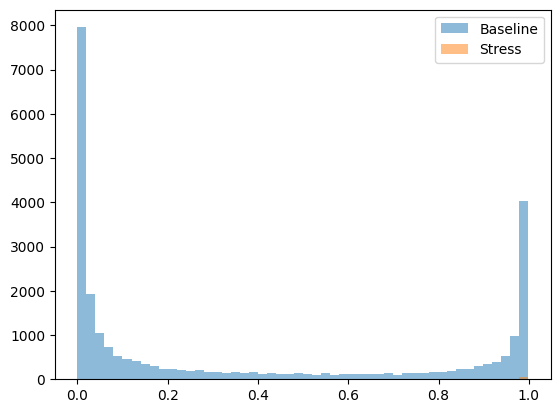

In [30]:
import matplotlib.pyplot as plt

plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label="Baseline")
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label="Stress")
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import average_precision_score
print("PR-AUC:", average_precision_score(y_test, y_prob))


PR-AUC: 0.055201349269863934


In [32]:
y_pred_new = (y_prob > 0.15).astype(int)
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       1.00      0.52      0.68     25624
           1       0.01      0.86      0.02       122

    accuracy                           0.52     25746
   macro avg       0.50      0.69      0.35     25746
weighted avg       0.99      0.52      0.68     25746

